<a href="https://colab.research.google.com/github/meriemdouider1/2/blob/main/code_p/mod%C3%A8le1-N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical# convert to one-hot-encoding
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline
from glob import glob
from keras import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model

from tqdm import tqdm_notebook
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model
from keras.optimizers import RMSprop


In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"meryemdouider","key":"e6d4d9e76ba23b2dc984f747113db5ce"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download "sshikamaru/glaucoma-detection"

kaggle.json
 88% 166M/188M [00:01<00:00, 150MB/s]
100% 188M/188M [00:01<00:00, 149MB/s]


In [6]:
!unzip glaucoma-detection.zip

Archive:  glaucoma-detection.zip
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/001.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/002.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/003.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/004.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/005.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/006.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/007.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/008.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/009.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/010.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glauc

# **Transfer learning**

Qu'est-ce que l'apprentissage par transfert?

L'apprentissage par transfert est une approche utilisée dans l'apprentissage automatique dans lequel un modèle créé et formé pour une tâche est réutilisé comme point de départ d'une tâche secondaire. L'apprentissage par transfert diffère de l'apprentissage automatique traditionnel car il implique l'utilisation d'un modèle pré-entraîné comme tremplin pour démarrer une tâche secondaire.

Cette approche imite la façon dont les humains appliquent les connaissances acquises pour une tâche à une nouvelle tâche. Par exemple, John Doe a appris à lire en première année. En dixième année, John a utilisé ses capacités de lecture en classe de chimie. Les connaissances qu'il avait acquises de la tâche principale (apprendre à lire) sont devenues la base sur laquelle il a commencé la tâche secondaire (apprendre la chimie).



Les avantages de l'utilisation de l'apprentissage par transfert et de l'apprentissage profond :

Prendre un modèle qui a déjà été formé dans un domaine spécifique et le réappliquer à un autre domaine présente de nombreux avantages. Certains des principaux avantages sont énumérés ci-dessous.

- Moins de données d'entraînement: commencer à entraîner un modèle à partir de zéro demande beaucoup de travail et nécessite beaucoup de données. Par exemple, si nous voulons créer un nouvel algorithme capable de détecter un froncement de sourcils, nous avons besoin de beaucoup de données d'entraînement. Notre modèle devra d'abord apprendre à détecter les visages, et ce n'est qu'alors qu'il pourra apprendre à détecter des expressions, telles que les froncements de sourcils. Au lieu de cela, si nous utilisons un modèle qui a déjà appris à détecter les visages et que nous recyclons ce modèle pour détecter les froncements de sourcils, nous pouvons obtenir le même résultat en utilisant beaucoup moins de données.
Les modèles se généralisent mieux 
- l'utilisation de l'apprentissage par transfert sur un modèle prépare le modèle à bien fonctionner avec des données sur lesquelles il n'a pas été formé. C'est ce qu'on appelle la généralisation. Les modèles qui ont été formés à l'aide de l'apprentissage par transfert sont mieux à même de généraliser d'une tâche à une autre car ils ont été formés pour apprendre à identifier les fonctionnalités qui peuvent être appliquées à de nouveaux contextes.
Rend l'apprentissage en profondeur plus accessible 
- l'utilisation de l'apprentissage par transfert facilite l'utilisation de l'apprentissage en profondeur. Il est possible d’obtenir les résultats souhaités sans être un expert en deep learning, en utilisant un modèle créé par un spécialiste du deep learning et en l’appliquant à un nouveau problème.

####Préparation des données entraînement /test / validation : 



In [7]:
DATAGlua_Train = '/content/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train'
DATAGlua_Test = '/content/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'

notre jeu deux de données est divisé en deux partie : 
*   des données avec un Gluacoma_positive
*   des données avec un Gluacoma_négative



In [8]:
CATEGORIES  = list()
for root, dirs, files in os.walk(DATAGlua_Train, topdown=False):
    for name in dirs:
        CATEGORIES.append(os.path.join(name))
print (CATEGORIES)

['Glaucoma_Positive', 'Glaucoma_Negative']



Division l'ensemble de données d'entraînement en x_train_data et y_train_data  : (x_train_data : 'les images' , y_train_data : 'label / catégorie ')

In [9]:
x_train_data = []
y_train_data = []
IMG_SIZE=224
def creation_train_data():
    for category in CATEGORIES:
      path = os.path.join(DATAGlua_Train, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_train_data.append(new_array)
            y_train_data.append(class_num)
        except Exception as e:
            pass
creation_train_data()

Division l'ensemble de données test en x_test_data et y_test_data  : (x_test_data : 'les images' , y_test_data : 'label / catégorie ')




In [10]:
x_test_data = []
y_test_data = []
IMG_SIZE=224
def creation_test_data():
    for category in CATEGORIES:
      path = os.path.join(DATAGlua_Test, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_test_data.append(new_array)
            y_test_data.append(class_num)
        except Exception as e:
            pass
creation_test_data ()

Division l'ensemble de données x_train_data et y_train_data en données d’entraînement (X_Train,Y_Train) et données de validation   (Y_train,Y_val) 

In [11]:
X_Train, X_Val, Y_Train, Y_Val = train_test_split(x_train_data, y_train_data, test_size=0.05, random_state=1)

In [12]:
len(Y_Train)

494

In [13]:
len(Y_Val)

26

In [14]:
X_Train = np. squeeze(np.array(X_Train))
X_Val = np. squeeze(np.array(X_Val))
Y_Train = np. squeeze(np.array(Y_Train))
Y_Val = np. squeeze(np.array(Y_Val))
x_test_data = np. squeeze(np.array(x_test_data))

In [15]:
X_Train.shape

(494, 224, 224, 3)

In [16]:
X_Val.shape

(26, 224, 224, 3)

In [17]:
Y_Train.shape

(494,)

In [18]:
Y_Val.shape

(26,)

In [19]:
x_test_data.shape

(130, 224, 224, 3)

In [20]:
Y_Train = to_categorical(Y_Train)
Y_Val = to_categorical(Y_Val)

In [21]:
Y_Train.shape

(494, 2)

In [22]:
Y_Val.shape

(26, 2)

# **Transfer learning**

# **Création du modèle**: 


Qu'est-ce qu'un modèle pré-entraîné ?
Un modèle pré-entraîné a été préalablement formé sur un ensemble de données et contient les pondérations et les biais qui représentent les caractéristiques de l'ensemble de données sur lequel il a été formé. Les fonctionnalités apprises sont souvent transférables à différentes données. Par exemple, un modèle formé sur un grand ensemble de données d'images d'oiseaux contiendra des caractéristiques apprises telles que des arêtes ou des lignes horizontales que vous seriez transférables à votre ensemble de données.


## **modèle 1 :** 

**inception_resnet_v2**
Inception-ResNet-v2 est une architecture neuronale convolutionnelle qui s'appuie sur la famille d'architectures Inception . nception-ResNet-v2 est un réseau neuronal est formé sur plus d'un million d'images de la base de données ImageNet . Le réseau comprend plusieurs couches de profondeur et peut classer les images en 1000 catégories d'objets . https://keras.io/api/applications/inceptionresnetv2/

In [23]:
from tensorflow.keras.applications import inception_resnet_v2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten



In [24]:
IMG_SHAPE = (224, 224,3)

importer le modèle pré-entraîne resnet_v2:



In [25]:
base_model3 = inception_resnet_v2.InceptionResNetV2
base_model3 = base_model3(weights='imagenet',input_shape=IMG_SHAPE, include_top=False)

219062272/219055592 [==============================] - 1s 0us/step



affichage les layers du modèle resnet_v2 et Figer le modèle pré-entraine en utilisant la commande layer.trainable = False

In [26]:
for layer in base_model3.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(base_model3.layers))

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed_5b
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
conv2d_12
conv2d_14
conv2d_17
batch_normalization_12
batch_normalization_14
batch_normalization_17
activation_12
activation_14
activation_17
block35_1_mixed
block35_1_conv
block35_1
block35_1_ac
conv2d_21
batch_normalization_21
activation_21
conv2d_19
conv2d_22
batc

In [27]:
base_model3.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

Création d'un nouveau modèle qui va se baser sur les résultas du modèle pré-entraîne :

In [28]:
x = Flatten ()(base_model3.output)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
# Ajouter une dernière couche sigmoïde pour la classification
x = layers.Dense(2, activation='sigmoid')(x)

In [29]:
# Configurer et compiler le modèle
model1 = Model(base_model3.input, x)
optimizer = RMSprop(lr=0.0001)
model1.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [30]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Utilisation d'ImageDataGenerator pour augmenter les données du test et normlaiser les données  :
ImageDataGenerator est un moyen de générer des images transformées en déplacement. Le but final est de réduire le sur-ajustement du modèle.
une étape importante avant d'entrainer le modèle est la normalisation pour mettre à l'échelle les valeurs d'entrée (initialement dans la plage [0, 255]) à la plage [0, 1]. 
Pour la normalisation des données, la division par la valeur maximale est une solution rapide et facile pour la normalisation car les valeurs minimale et maximale sont connues et constantes (comprises entre 0 et 255). J'ai choisi un ensemble de paramètres pour l'augmentation des données qui correspondent à l'ensemble de données MNIST: une rotation aléatoire d'au plus 40 ° et la possibilité de zoomer ou de dézoomer un peu.


une étape importante avant d'entrainer le modèle est la normalisation pour mettre à l'échelle les valeurs d'entrée (initialement dans la plage [0, 255]) à la plage [0, 1]. 

Augmentation et normalisation du données test :

In [31]:
train_datagen = ImageDataGenerator(
    validation_split=0.2, 
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.02,
)
train_iterator= train_datagen.flow(
    x=X_Train,
    y=Y_Train,
    batch_size=16,
    subset='training'
)

résultats de l'augmentation sur une image des données test :

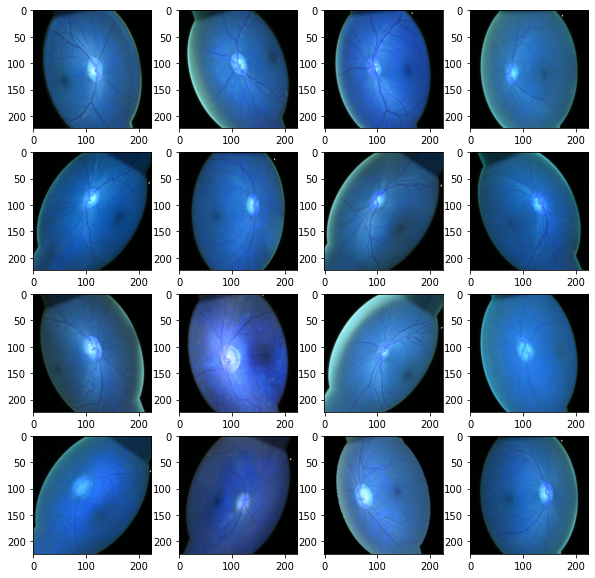

In [32]:
plt.gcf().set_size_inches(10, 10)
for x_batch, y_batch in train_iterator:
    for i in range(0, 16):
        plt.subplot(4, 4, i+1)
        plt.imshow(x_batch[i])
    break

normalisation du données validation :

In [33]:
val_datagen=ImageDataGenerator(rescale=1./255)

In [34]:
train_iterator[1]

(array([[[[3.92156886e-03, 3.92156886e-03, 3.92156886e-03],
          [3.92156886e-03, 3.92156886e-03, 3.92156886e-03],
          [3.92156886e-03, 3.92156886e-03, 3.92156886e-03],
          ...,
          [8.02523717e-02, 3.33053797e-01, 3.74649614e-01],
          [7.54271075e-02, 3.37254912e-01, 3.81783485e-01],
          [7.05882385e-02, 3.44238698e-01, 3.86489391e-01]],
 
         [[3.92156886e-03, 3.92156886e-03, 3.92156886e-03],
          [3.92156886e-03, 3.92156886e-03, 3.92156886e-03],
          [3.92156886e-03, 3.92156886e-03, 3.92156886e-03],
          ...,
          [7.97835216e-02, 3.37254912e-01, 3.75974953e-01],
          [7.05882385e-02, 3.38430136e-01, 3.87941509e-01],
          [7.05882385e-02, 3.51865739e-01, 3.84582609e-01]],
 
         [[3.92156886e-03, 3.92156886e-03, 3.92156886e-03],
          [3.92156886e-03, 3.92156886e-03, 3.92156886e-03],
          [3.92156886e-03, 3.92156886e-03, 3.92156886e-03],
          ...,
          [7.40632415e-02, 3.37254912e-01, 3.8360


Entraînement du modèle avec des layers du modèle pré-entrâine ( en mode freeze)

In [35]:
train_model = model1.fit(train_iterator,epochs=16,
                    validation_data=val_datagen.flow(X_Val, Y_Val))

Epoch 1/16
25/25 [==============================] - 24s 366ms/step - loss: 4.5560 - accuracy: 0.5438 - val_loss: 1.0752 - val_accuracy: 0.4231
Epoch 2/16
25/25 [==============================] - 5s 207ms/step - loss: 1.3850 - accuracy: 0.6146 - val_loss: 1.4245 - val_accuracy: 0.1538
Epoch 3/16
25/25 [==============================] - 5s 208ms/step - loss: 1.0376 - accuracy: 0.6449 - val_loss: 0.4138 - val_accuracy: 0.8462
Epoch 4/16
25/25 [==============================] - 5s 205ms/step - loss: 0.7610 - accuracy: 0.7318 - val_loss: 0.3878 - val_accuracy: 0.8462
Epoch 5/16
25/25 [==============================] - 5s 205ms/step - loss: 0.8184 - accuracy: 0.6946 - val_loss: 0.6679 - val_accuracy: 0.5769
Epoch 6/16
25/25 [==============================] - 5s 204ms/step - loss: 0.7778 - accuracy: 0.6422 - val_loss: 0.4153 - val_accuracy: 0.8077
Epoch 7/16
25/25 [==============================] - 5s 205ms/step - loss: 0.8619 - accuracy: 0.6051 - val_loss: 0.4015 - val_accuracy: 0.8462
Epoch


# **fine-tuning**

dégelons maintenant le modèle de base et formons l'ensemble du modèle de bout en bout avec un faible taux d'apprentissage.

Il est important de noter que bien que le modèle de base devienne entraînable, il fonctionne toujours en mode inférence puisque nous avons passé training = False lors de son appel lorsque nous avons construit le modèle.

In [36]:
for layer in model1.layers:
    layer.trainable = True

In [37]:
optimizer = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [38]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [39]:
train_model = model1.fit(train_iterator, epochs=16,
                    validation_data=val_datagen.flow(X_Val, Y_Val))

Epoch 1/16
25/25 [==============================] - 26s 478ms/step - loss: 0.5579 - acc: 0.7548 - val_loss: 0.4510 - val_acc: 0.8462
Epoch 2/16
25/25 [==============================] - 9s 340ms/step - loss: 0.5359 - acc: 0.7394 - val_loss: 0.3960 - val_acc: 0.8462
Epoch 3/16
25/25 [==============================] - 9s 345ms/step - loss: 0.5128 - acc: 0.7732 - val_loss: 0.3513 - val_acc: 0.8462
Epoch 4/16
25/25 [==============================] - 9s 348ms/step - loss: 0.5241 - acc: 0.7546 - val_loss: 0.3483 - val_acc: 0.8846
Epoch 5/16
25/25 [==============================] - 9s 343ms/step - loss: 0.5243 - acc: 0.7204 - val_loss: 0.3538 - val_acc: 0.8462
Epoch 6/16
25/25 [==============================] - 9s 341ms/step - loss: 0.5256 - acc: 0.7377 - val_loss: 0.3490 - val_acc: 0.8462
Epoch 7/16
25/25 [==============================] - 9s 337ms/step - loss: 0.5453 - acc: 0.7252 - val_loss: 0.3494 - val_acc: 0.8462
Epoch 8/16
25/25 [==============================] - 9s 337ms/step - loss: 0

In [ ]:
validation_data=val_datagen.flow(X_Val, Y_Val)

In [41]:
loss_val, acc_val = model1.evaluate(validation_data, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

1/1 [==============================] - 0s 179ms/step - loss: 0.3270 - acc: 0.9231
Validation: accuracy = 0.923077  ;  loss_v = 0.326957


In [42]:
model1.save("resnet")

INFO:tensorflow:Assets written to: resnet/assets


Text(0.5, 1.0, 'Training and validation loss')

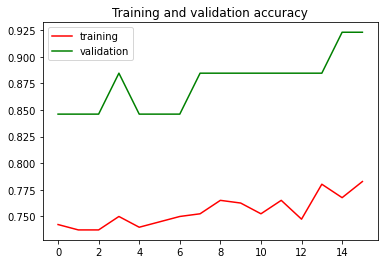

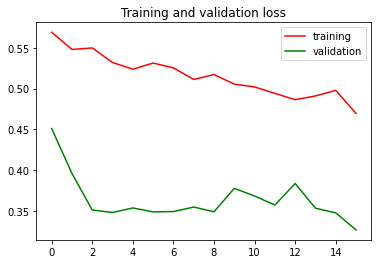

In [43]:
#accuracy est un moyen de mesurer la fréquence à laquelle l'algorithme classe correctement un point de données.
# acc contient les valeurs des accuracy pour les données test  :
acc = train_model.history['acc']
# val_acc contient les valeurs des accuracy pour les données validation   :
val_acc = train_model.history['val_acc']

#loss_function : Cette fonction calculera essentiellement les performances de notre modèle en comparant ce que le modèle prédit avec la valeur réelle qu'il est censé produire.
# loss contient les valeurs du loss_function pour les données test  :
loss = train_model.history['loss']
# val_loss contient les valeurs du loss_function pour les données test  :
val_loss = train_model.history['val_loss']

#les nombre des epochs pour comparer les valeurs des accuracy ou les valeurs des loss function par rapport à leur évolution par rapport au nomre des epochs
epochs = range(len(acc))

# le première graph représente les valeurs des accuracy pour les données test et validation par rapport au nombre des epochs 
plt.plot(epochs, acc,color='r',label = "training")
plt.plot(epochs, val_acc,color='g',label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()
#le deuxième graph représente les valeurs des accuracy pour les données test et validation par rapport au nombre des epochs 
plt.plot(epochs, loss,color='r', label = "training")
plt.plot(epochs, val_loss,color='g',label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

**Test :**

In [44]:
Y_test=to_categorical(y_test_data)


In [45]:
loss_test, acc_test = model1.evaluate(train_datagen.flow(x_test_data,Y_test, batch_size=32), verbose=1)

print("Test: accuracy = %f ; loss = %f" % (acc_test, loss_test))

5/5 [==============================] - 2s 308ms/step - loss: 0.5968 - acc: 0.7077
Test: accuracy = 0.707692 ; loss = 0.596756
5/5 [==============================] - 2s 308ms/step - loss: 0.5968 - acc: 0.7077
Test: accuracy = 0.707692 ; loss = 0.596756
